In [1]:
from __future__ import print_function

In [14]:
from functools import partial

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np

from astropy.modeling import models, fitting

Now we try and build the mfe single tube model.

In [3]:
import pysac.mhs_atmosphere as atm
from pysac.mhs_atmosphere.parameters.model_pars import mfe_setup as model_pars

In [86]:
# Cheeky Reset to Photosphere
#model_pars['xyz'][4] = 0*u.Mm
model_pars['radial_scale'] = 0.03938*u.Mm

In [87]:
keys = ['B_corona', 'coratio', 'chratio', 'radial_scale', 'chrom_scale', 'corona_scale', 'xyz']
for key in keys:
    print(key, model_pars[key])

B_corona 0.000485 T
coratio 0.0
chratio 1.0
radial_scale 0.03938 Mm
chrom_scale 0.4 Mm
corona_scale 0.25 Mm
xyz [<Quantity -1.0 Mm>, <Quantity 1.0 Mm>, <Quantity -1.0 Mm>, <Quantity 1.0 Mm>, <Quantity 0.035 Mm>, <Quantity 1.6 Mm>]


In [88]:
# model setup
scales, physical_constants = atm.units_const.get_parameters()
option_pars = atm.options.set_options(model_pars, False, l_gdf=True)
coords = atm.model_pars.get_coords(model_pars['Nxyz'], u.Quantity(model_pars['xyz']))

#interpolate the hs 1D profiles from empirical data source[s]
empirical_data = atm.hs_atmosphere.read_VAL3c_MTW(mu=physical_constants['mu'])
table = atm.hs_atmosphere.interpolate_atmosphere(empirical_data, coords['Zext'])

In [89]:
#==============================================================================
#calculate 1d hydrostatic balance from empirical density profile
#==============================================================================
# the hs pressure balance is enhanced by pressure equivalent to the
# residual mean coronal magnetic pressure contribution once the magnetic
# field has been applied
magp_meanz = np.ones(len(coords['Z'])) * u.one
magp_meanz *= model_pars['pBplus']**2/(2*physical_constants['mu0'])

pressure_z, rho_z, Rgas_z = atm.hs_atmosphere.vertical_profile(coords['Z'], table, magp_meanz,
                                                               physical_constants, coords['dz'])

In [90]:
x, y, z = u.Quantity(np.mgrid[coords['xmin']:coords['xmax']:1j*model_pars['Nxyz'][0],
                              coords['ymin']:coords['ymax']:1j*model_pars['Nxyz'][1],
                              coords['zmin']:coords['zmax']:1j*model_pars['Nxyz'][2]], unit=coords['xmin'].unit)

In [91]:
xi, yi, Si = atm.flux_tubes.get_flux_tubes(model_pars, coords, option_pars)

In [92]:
allmag = atm.flux_tubes.construct_magnetic_field(x, y, z,
                                                 xi[0], yi[0], Si[0],
                                                 model_pars, option_pars,
                                                 physical_constants,
                                                 scales)
pressure_m, rho_m, Bx, By ,Bz, Btensx, Btensy = allmag

/home/stuart/GitHub/SWAT/pysac/pysac/mhs_atmosphere/mhs_model/flux_tubes.py:303: Warning: pbbal.max() = -0.0860956724487 kg / (m s2)
  warnings.warn("pbbal.max() = {}".format(pbbal.max().decompose()), Warning)


In [93]:
# local proc 3D mhs arrays
pressure, rho = atm.mhs_3D.mhs_3D_profile(z,
                                          pressure_z,
                                          rho_z,
                                          pressure_m,
                                          rho_m)
magp = (Bx**2 + By**2 + Bz**2) / (2.*physical_constants['mu0'])
energy = atm.mhs_3D.get_internal_energy(pressure, magp, physical_constants)

In [94]:
x_lin = np.linspace(coords['xmin'], coords['xmax'], model_pars['Nxyz'][0])
bmag = np.sqrt((Bx**2 + By**2 + Bz**2))[:,64,0].to(u.mT)

gaussian = models.Gaussian1D()
bmag_fit = fitting.LevMarLSQFitter()(gaussian, x_lin, bmag)

fwhm = 2.*np.sqrt(2*np.log(2))*bmag_fit.stddev.value
fwhm = np.abs(fwhm) * u.Mm

fwtm = 2.*np.sqrt(2*np.log(10))*bmag_fit.stddev.value
fwtm = np.abs(fwtm) * u.Mm

u.Quantity([fwhm, fwtm]).to(u.km)

<Quantity [ 102.43726264, 186.70376611] km>

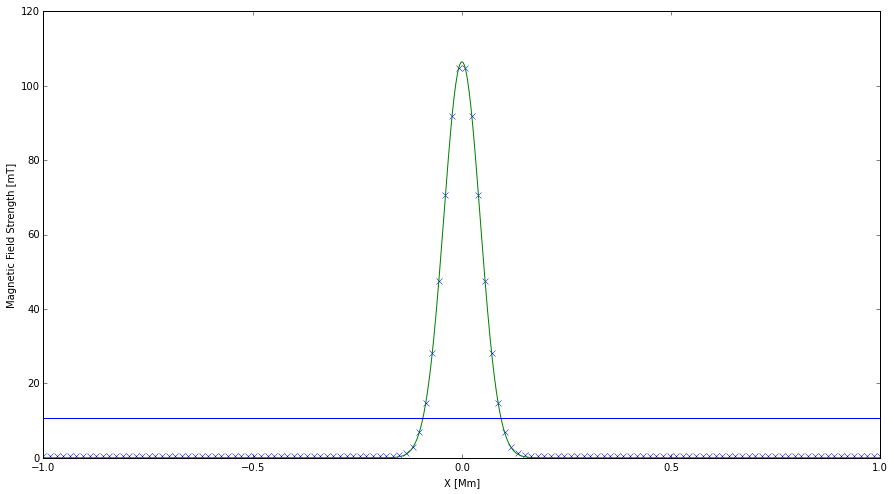

In [95]:
%matplotlib inline
fig = plt.figure(figsize=(15,8))
plt.plot(x_lin, bmag.to(u.mT), 'x')
X = np.linspace(coords['xmin'], coords['xmax'], 1000)
plt.plot(X, bmag_fit(X.value))

plt.xlabel("X [{}]".format(x.unit))
plt.ylabel("Magnetic Field Strength [{}]".format(bmag.unit))
plt.axhline(y=bmag_fit.amplitude.value/10)

## Now for some plotting

In [14]:
import yt

In [15]:
def magnetic_field_strength(field, data):
        return np.sqrt(data["magnetic_field_x"]**2 + data["magnetic_field_y"]**2 + data["magnetic_field_z"]**2)
yt.add_field(("gas","magnetic_field_strength"),
             function=magnetic_field_strength,
             units = "T")

In [16]:
def plasma_beta(field, data):
        return data['pressure'] / data['magnetic_pressure']
yt.add_field(("gas","plasma_beta"),
             function=plasma_beta,
             units = "")

In [17]:
def alfven_speed(field, data):
    return np.sqrt(2.*data['magnetic_pressure']/data['density'])
yt.add_field(("gas","alfven_speed"),
             function=alfven_speed,
             units = "m/s")

In [18]:
def sound_speed(field, data):
    cspeed = np.sqrt(physical_constants['gamma']*pressure/rho)
    return cspeed
yt.add_field(("gas","sound_speed"),
             function=sound_speed,
             units = "m/s", force_override=True)

In [19]:
bbox = u.Quantity([u.Quantity([coords['xmin'], coords['xmax']]),
                   u.Quantity([coords['ymin'], coords['ymax']]),
                   u.Quantity([coords['zmin'], coords['zmax']])]).to(u.m).value

In [20]:
data = {'magnetic_field_x':yt.YTQuantity.from_astropy(Bx.decompose()),
        'magnetic_field_y':yt.YTQuantity.from_astropy(By.decompose()),
        'magnetic_field_z':yt.YTQuantity.from_astropy(Bz.decompose()),
        'pressure': yt.YTQuantity.from_astropy(pressure.decompose()),
        'magnetic_pressure': yt.YTQuantity.from_astropy(magp.decompose()),
        'density': yt.YTQuantity.from_astropy(rho.decompose())}

ds = yt.load_uniform_grid(data, x.shape,
                          length_unit='m', magnetic_unit='T', mass_unit='kg',
                          periodicity=[False]*3, bbox=bbox)

yt : [INFO     ] 2015-09-02 11:38:39,824 Parameters: current_time              = 0.0
yt : [INFO     ] 2015-09-02 11:38:39,825 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2015-09-02 11:38:39,826 Parameters: domain_left_edge          = [-1000000. -1000000.    35000.]
yt : [INFO     ] 2015-09-02 11:38:39,828 Parameters: domain_right_edge         = [ 1000000.  1000000.  1600000.]
yt : [INFO     ] 2015-09-02 11:38:39,830 Parameters: cosmological_simulation   = 0.0


In [21]:
slc = yt.SlicePlot(ds, 'x', 'alfven_speed', origin='lower-center-domain', axes_unit='Mm')
slc.set_cmap('all', 'OrRd')

seed_points = np.zeros([11,2]) + 1.52
seed_points[:,0] = np.linspace(-0.99, 0.95, seed_points.shape[0], endpoint=True)
slc.annotate_streamlines('magnetic_field_y', 'magnetic_field_z', field_color='magnetic_field_strength',
                         plot_args={'start_points':seed_points, 'density':15, 'cmap':'winter',
                                    'norm': mpl.colors.LogNorm(*ds.all_data().quantities.extrema("magnetic_field_strength"))})
slc.annotate_contour('plasma_beta', label=True)

yt : [INFO     ] 2015-09-02 11:38:39,960 Loading field plugins.
yt : [INFO     ] 2015-09-02 11:38:39,961 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2015-09-02 11:38:39,962 Loaded astro (15 new fields)
yt : [INFO     ] 2015-09-02 11:38:39,963 Loaded cosmology (22 new fields)
yt : [INFO     ] 2015-09-02 11:38:39,965 Loaded fluid (63 new fields)
yt : [INFO     ] 2015-09-02 11:38:39,967 Loaded fluid_vector (95 new fields)
yt : [INFO     ] 2015-09-02 11:38:39,969 Loaded geometric (111 new fields)
yt : [INFO     ] 2015-09-02 11:38:39,970 Loaded local (115 new fields)
yt : [INFO     ] 2015-09-02 11:38:39,972 Loaded magnetic_field (119 new fields)
yt : [INFO     ] 2015-09-02 11:38:39,973 Loaded my_plugins (119 new fields)
yt : [INFO     ] 2015-09-02 11:38:39,974 Loaded species (121 new fields)
-c:2: RuntimeWarning: invalid value encountered in sqrt
yt : [INFO     ] 2015-09-02 11:38:40,601 xlim = -1000000.000000 1000000.000000
yt : [INFO     ] 2015-09-02 11:38:40,603 ylim = 35000.0

YTPlotCallbackError: annotate_streamlines callback failed with the following error: streamplot() got an unexpected keyword argument 'start_points'

In [ ]:
slc = yt.SlicePlot(ds, 'x', 'magnetic_field_strength', origin='lower-center-domain',
                   axes_unit='Mm')
slc.set_cmap('all', 'BuPu')
#slc.annotate_contour('plasma_beta')

seed_points = np.zeros([11,2]) + 1.52
seed_points[:,0] = np.linspace(-0.99, 0.95, seed_points.shape[0], endpoint=True)
slc.annotate_streamlines('magnetic_field_y', 'magnetic_field_z', field_color='magnetic_field_strength',
                         plot_args={'start_points':seed_points, 'density':15, 'cmap':'winter', 'linewidth': 2,
                                    'norm': slc.plots['magnetic_field_strength'].image.norm})

In [ ]:
slc = yt.SlicePlot(ds, 'z', 'magnetic_field_strength', origin='center-domain',
                   axes_unit='km', center=("max", "magnetic_field_strength"), width=(0.5, "Mm"))
slc.set_cmap('all', 'Oranges')
slc.annotate_contour('magnetic_field_strength', take_log=False,
                     plot_args={'levels':[ds.all_data().quantities.extrema("magnetic_field_strength")[1]/2.],
                                'linewidths':3,
                                'colors':'black'})

# Comparing pysac to the Original Data

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u

import yt
import pysac.yt

from astropy.modeling import models, fitting

In [ ]:
ds = yt.load('/home/stuart/GitHub/Thesis/thesis/Chapter3/Data/Slog_p240-0_A10_B005_00001.gdf')
type(ds)

In [ ]:
slc = yt.SlicePlot(ds, 'x', 'magnetic_field_strength', origin='lower-left-domain',
                   axes_unit='Mm')
slc.set_cmap('all', 'BuPu')
slc.annotate_contour('plasma_beta')

seed_points = np.zeros([11,2]) + 152
seed_points[:,0] = np.linspace(5, 190, seed_points.shape[0], endpoint=True)
slc.annotate_streamlines('mag_field_y', 'mag_field_z', field_color='magnetic_field_strength', 
                        plot_args={'start_points':seed_points, 'density':15, 'cmap':'winter', 'linewidth': 2,
                                   'norm': slc.plots['magnetic_field_strength'].image.norm})
slc.show()

In [ ]:
cg = ds.index.grids[0]

In [ ]:
xmin, xmax = ds.domain_left_edge[0]/1e6, ds.domain_right_edge[0]/1e8
xmin = xmin.value
xmax = xmax.value
xmin, xmax

In [ ]:
x_lin = np.linspace(xmin, xmax, ds.domain_dimensions[0])
bmag = cg['magnetic_field_strength'][:,64,0].to_astropy().to(u.mT)

gaussian = models.Gaussian1D()
bmag_fit = fitting.LevMarLSQFitter()(gaussian, x_lin, bmag)

fwhm = 2.*np.sqrt(2*np.log(2))*bmag_fit.stddev.value
fwhm = np.abs(fwhm) * u.Mm

fwtm = 2.*np.sqrt(2*np.log(10))*bmag_fit.stddev.value
fwtm = np.abs(fwtm) * u.Mm

u.Quantity([fwhm, fwtm]).to(u.km)

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(15,8))
plt.plot(x_lin, bmag.to(u.mT), 'x')
X = np.linspace(xmin, xmax, 1000)
plt.plot(X, bmag_fit(X))

plt.xlabel("X [{}]".format(fwhm.unit))
plt.ylabel("Magnetic Field Strength [{}]".format(bmag.unit))
plt.axhline(y=bmag_fit.amplitude.value/10)